In [1]:
from pathlib import Path

import nibabel as nib
import sys
sys.path.append("ComputeCanada/frequency_tagging")
from utils import (
    get_roi_colour_codes,
    change_font,
    HCP_ATLAS as hcp_label,
    dfm_generate_single_subject_maps,
    NORMAL_3T_SUB_IDS,
    NORMAL_7T_SUB_IDS,
    MAIN,
)
change_font()

tmpdir = Path("/tmp")
from utils import (
    load_mean_dtseries,
    WORKING_DIR,
    crop_and_save,
)
from wbplot import dscalar

REPRO_MAP = WORKING_DIR / "figures" / "im_mapping" / "run_level_reproducibility"
if not REPRO_MAP.exists():
    REPRO_MAP.mkdir(parents=True, exist_ok=True)

VERTEX_TO = 59412
PALETTE_PARAMS = {
    "disp-zero": False,
    "disp-neg": False,
    "disp-pos": True,
    "pos-user": (0, 1),
    "neg-user": (-1,0),
    "interpolate": True,
}
# Cropped settings
LEFT=590;TOP=80;RIGHT=1140;BOTTOM=460


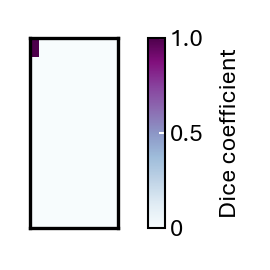

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(1,1), dpi=300, layout="tight")

data = np.zeros((10, 10))
data[0,0] = 1
data[0,1] = 0

ax.set_xticks([])
ax.set_yticks([])
cax = ax.imshow(data, cmap="BuPu", aspect="auto")
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="20%", pad=.1)
cbar = fig.colorbar(cax, cax=cbar_ax)
for s in cbar.ax.spines.values():
    s.set_linewidth(.5)
cbar.ax.set_yticks([0,.5,1])
cbar.ax.set_yticklabels([0,.5,1.], fontsize=6)
cbar.ax.tick_params(axis="both",width=.5,pad=1, length=1.4,direction='in', color='white')
cbar.ax.set_ylabel("Dice coefficient",fontsize=6)

fig.savefig(MAIN / "cbar.png")

In [3]:
all_masks = {}
main_dscalars = {}
ses_dscalars = {}
run_dscalars = {}
sub_ids = []
pval_type = "uncp"
for f_type, f in zip(["f1","f2","im"],[.125,.2,.075]):
    for sub_id in NORMAL_3T_SUB_IDS:
        if f_type == "f1":
            sub_ids.append(sub_id)
        _all_masks = !ls /scratch/*3T*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain*/run-*/GLM/*frequency-{f}_stat.dscalar.nii
        _main_dscalars = !ls /scratch/*3T*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain*/run-ALL/GLM/*frequency-{f}_stat.dscalar.nii
        _ses_dscalars = !ls /scratch/*3T*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain*/run-0?/GLM/*frequency-{f}_p_value.dscalar.nii
        _run_dscalars = !ls /scratch/*3T*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain*/run-??X??/GLM/*frequency-{f}_p_value.dscalar.nii
        all_masks[f"{sub_id}_{f_type}"] = _all_masks
        main_dscalars[f"{sub_id}_{f_type}"] = _main_dscalars
        ses_dscalars[f"{sub_id}_{f_type}"] = _ses_dscalars
        run_dscalars[f"{sub_id}_{f_type}"] = _run_dscalars
    for sub_id in NORMAL_7T_SUB_IDS:
        if f_type == "f1":
            sub_ids.append(sub_id)
        _all_masks = !ls /scratch/*7T*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-AttendAway*/run-*/GLM/*frequency-{f}_stat.dscalar.nii
        _main_dscalars = !ls /scratch/*7T*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-AttendAway*/run-ALL/GLM/*frequency-{f}_stat.dscalar.nii
        _ses_dscalars = !ls /scratch/*7T*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-AttendAway*/run-0?/GLM/*frequency-{f}_p_value.dscalar.nii
        _run_dscalars = !ls /scratch/*7T*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-AttendAway*/run-??X??/GLM/*frequency-{f}_p_value.dscalar.nii
        all_masks[f"{sub_id}_{f_type}"] = _all_masks
        main_dscalars[f"{sub_id}_{f_type}"] = _main_dscalars
        ses_dscalars[f"{sub_id}_{f_type}"] = _ses_dscalars
        run_dscalars[f"{sub_id}_{f_type}"] = _run_dscalars
task_map_f1 = {
    "020": {"A": .125, "B": .125, "C": .125}, 
    "021": {"D": .125, "E": .15, "F": .175},
}
task_map_f2 = {
    "020": {"A": .2, "B": .175, "C": .15}, 
    "021": {"D": .2, "E": .2, "F": .2},
}
task_map_im = {
    "020": {"A": .075, "B": .05, "C": .025}, 
    "021": {"D": .075, "E": .05, "F": .025},
}

for f_type in ["f1","f2","im"]:
    for sub_id in ["020","021"]:
        all_masks[f"{sub_id}_{f_type}"] = []
        main_dscalars[f"{sub_id}_{f_type}"] = []
        ses_dscalars[f"{sub_id}_{f_type}"] = []
        run_dscalars[f"{sub_id}_{f_type}"] = []
f_type = "f1"
for sub_id, task_to_f_map in task_map_f1.items():
    sub_ids.append(sub_id)
    for mri_id in ["3T","7T"]:
        for suffix, f in task_to_f_map.items():
            _all_masks = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-*/GLM/*frequency-{f}_stat.dscalar.nii
            _main_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-ALL/GLM/*frequency-{f}_stat.dscalar.nii
            _ses_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-IM*est/GLM/*frequency-{f}_p_value.dscalar.nii
            _run_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-*X??/GLM/*frequency-{f}_p_value.dscalar.nii
            all_masks[f"{sub_id}_{f_type}"] += _all_masks
            main_dscalars[f"{sub_id}_{f_type}"] += _main_dscalars
            ses_dscalars[f"{sub_id}_{f_type}"] += _ses_dscalars
            run_dscalars[f"{sub_id}_{f_type}"] += _run_dscalars
f_type = "f2"
for sub_id, task_to_f_map in task_map_f2.items():
    for mri_id in ["3T","7T"]:
        for suffix, f in task_to_f_map.items():
            _all_masks = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-*/GLM/*frequency-{f}_stat.dscalar.nii
            _main_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-ALL/GLM/*frequency-{f}_stat.dscalar.nii
            _ses_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-IM*est/GLM/*frequency-{f}_p_value.dscalar.nii
            _run_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-*X??/GLM/*frequency-{f}_p_value.dscalar.nii
            all_masks[f"{sub_id}_{f_type}"] += _all_masks
            main_dscalars[f"{sub_id}_{f_type}"] += _main_dscalars
            ses_dscalars[f"{sub_id}_{f_type}"] += _ses_dscalars
            run_dscalars[f"{sub_id}_{f_type}"] += _run_dscalars
f_type = "im"
for sub_id, task_to_f_map in task_map_im.items():
    for mri_id in ["3T","7T"]:
        for suffix, f in task_to_f_map.items():
            _all_masks = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-*/GLM/*frequency-{f}_stat.dscalar.nii
            _main_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-ALL/GLM/*frequency-{f}_stat.dscalar.nii
            _ses_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-IM*est/GLM/*frequency-{f}_p_value.dscalar.nii
            _run_dscalars = !ls /scratch/*{mri_id}*{pval_type}_bootstrap/first_level_analysis/sub-{sub_id}/ses-main/task-entrain{suffix}*/run-*X??/GLM/*frequency-{f}_p_value.dscalar.nii
            all_masks[f"{sub_id}_{f_type}"] += _all_masks
            main_dscalars[f"{sub_id}_{f_type}"] += _main_dscalars
            ses_dscalars[f"{sub_id}_{f_type}"] += _ses_dscalars
            run_dscalars[f"{sub_id}_{f_type}"] += _run_dscalars

In [4]:
sub_ids = ["000","002","003","004","009","005","006","007","008","Pilot001", "Pilot009", "Pilot010", "Pilot011","020","021"]

### run level

000_01
000_01
000_01
000_01
000_01
000_01
000_01
000_01
000_02
000_02
000_02
000_02
000_02
000_02
000_02
000_02
000_03
000_03
000_03
000_03
000_03
000_03
000_03
000_03
002_01
002_01
002_01
002_01
002_01
002_01
002_01
002_01
002_02
002_02
002_02
002_02
002_02
002_02
002_02
002_02
002_03
002_03
002_03
002_03
002_03
002_03
002_03
002_03
003_01
003_01
003_01
003_01
003_01
003_01
003_01
003_01
003_02
003_02
003_02
003_02
003_02
003_02
003_02
003_02
003_03
003_03
003_03
003_03
003_03
003_03
003_03
003_03
004_01
004_01
004_01
004_01
004_01
004_01
004_01
004_01
004_02
004_02
004_02
004_02
004_02
004_02
004_02
004_02
004_03
004_03
004_03
004_03
004_03
004_03
004_03
004_03
009_01
009_01
009_01
009_01
009_01
009_01
009_01
009_01
009_02
009_02
009_02
009_02
009_02
009_02
009_02
009_02
009_03
009_03
009_03
009_03
009_03
009_03
009_03
009_03
005_01
005_01
005_01
005_01
005_01
005_01
005_01
005_01
005_02
005_02
005_02
005_02
005_02
005_02
005_02
005_02
005_03
005_03
005_03
005_03
005_03
005_03
005_03

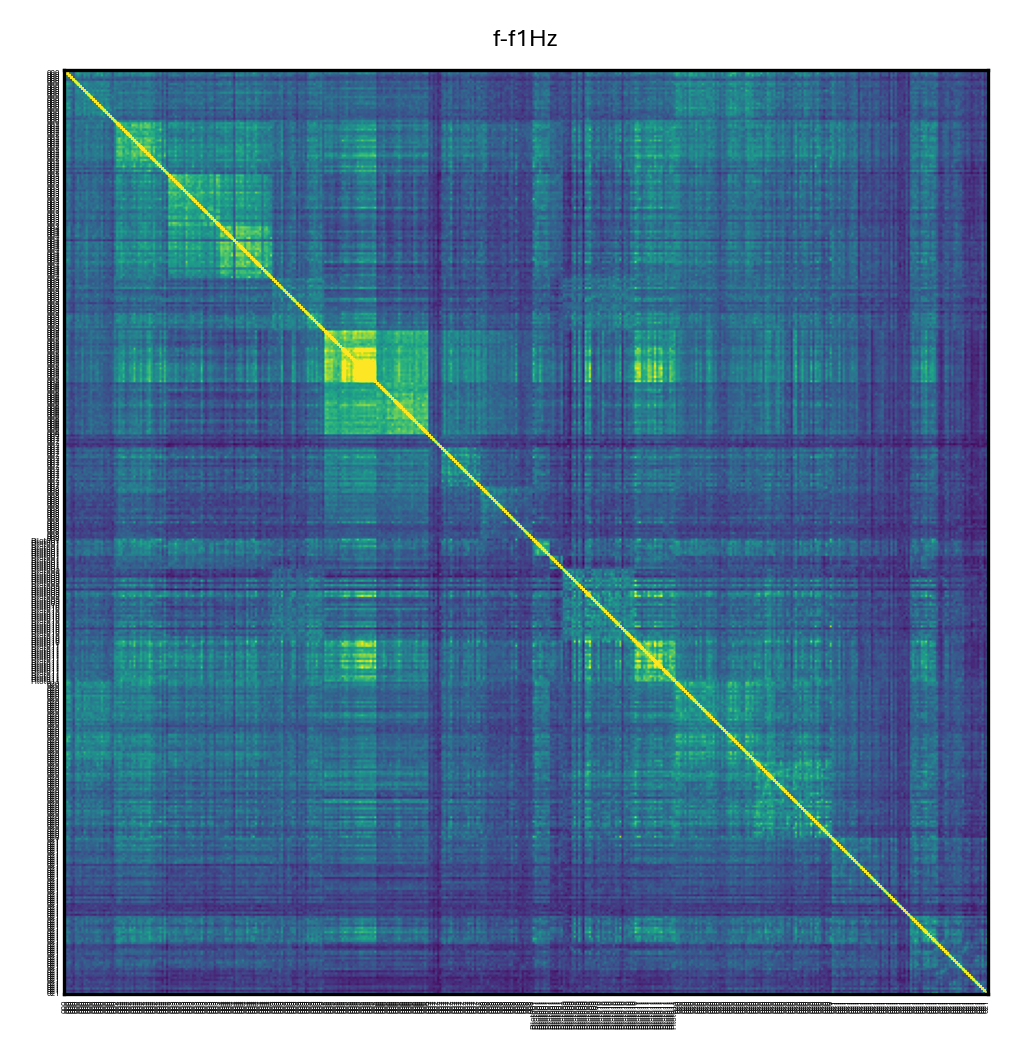

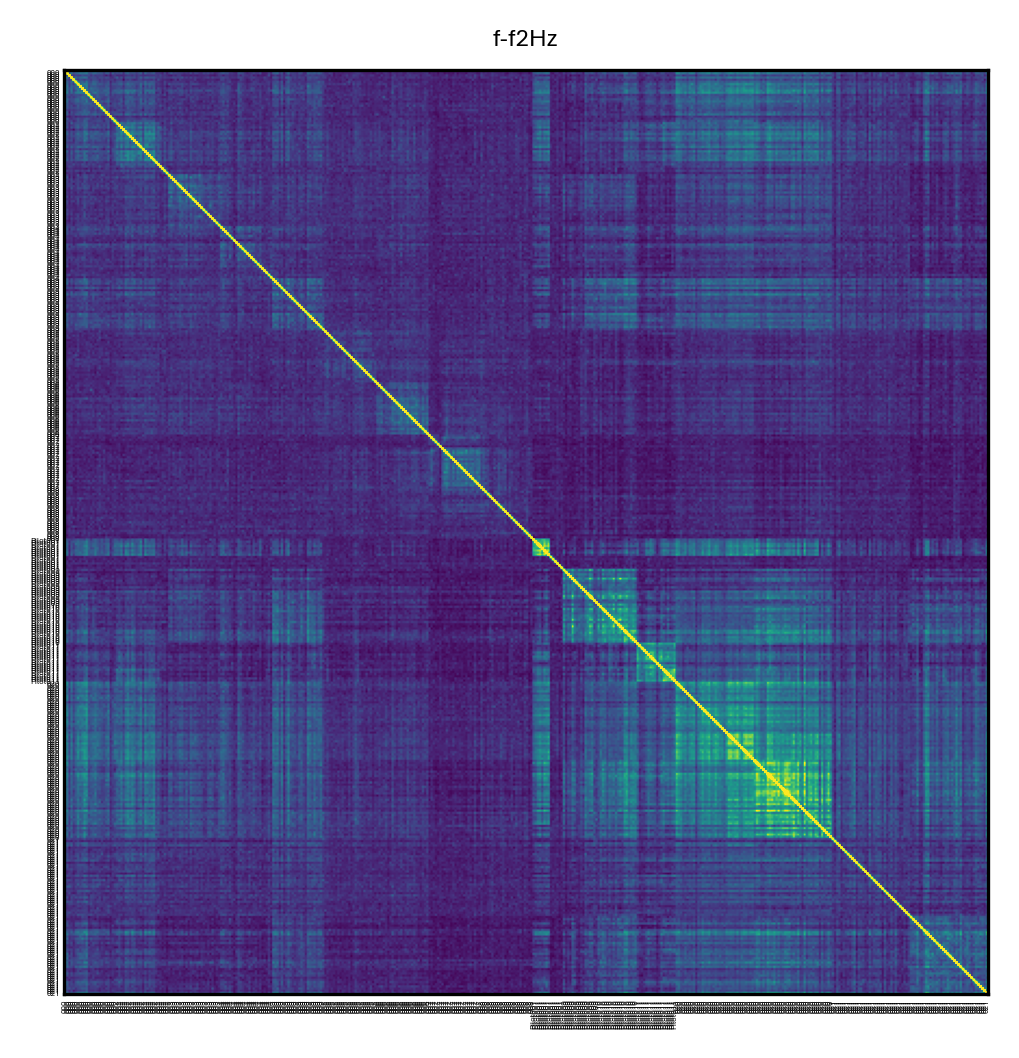

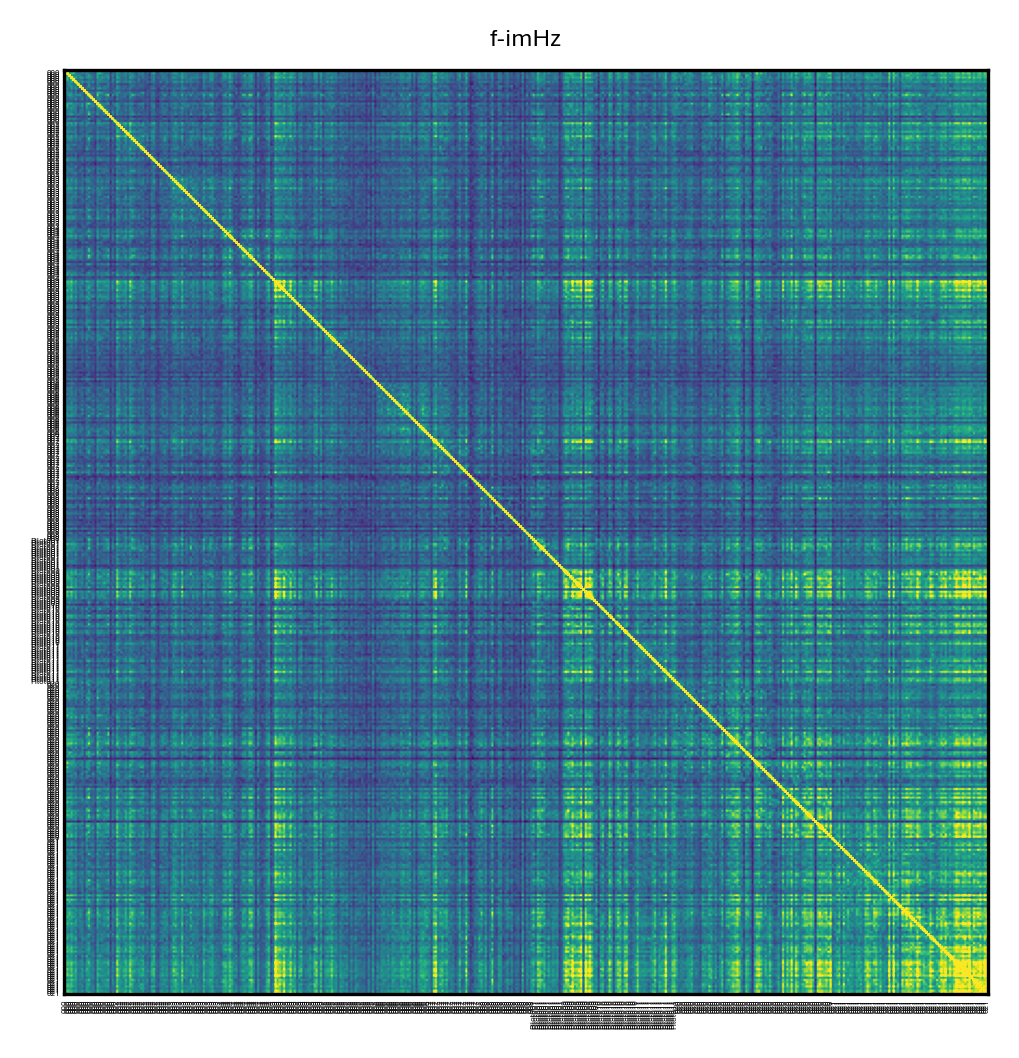

In [5]:
p_thr = .05
    
def dice_coefficient(col1, col2):
    intersection = np.sum(np.minimum(col1, col2))
    return 2 * intersection / (np.sum(col1) + np.sum(col2))

dice_matrix = {}
for f_type in ["f1", "f2", "im"]:
    
    # Global 
    mask = None
    n_masks = 0
    main_data = None
    run_ids = []
    run_data = None

    for sub_id in sub_ids:


        _all_masks = all_masks[f"{sub_id}_{f_type}"]
        _main_dscalar = main_dscalars[f"{sub_id}_{f_type}"][0]
        _run_dscalars = run_dscalars[f"{sub_id}_{f_type}"]
        
        # 1 - 
        n_masks += len(_all_masks)
        for i in _all_masks:
            _mask = (nib.load(i).get_fdata() > 0).astype(float)
            if mask is None:
                mask = _mask
            else:
                mask += _mask

        # 2 - main dscalar
        _main_data = nib.load(_main_dscalar).get_fdata()[0,:VERTEX_TO]
        _main_data = (_main_data < p_thr).astype(float)
        _main_data = _main_data[None,:]
        if main_data is None:
            main_data = _main_data
        else:
            main_data = np.vstack((main_data,_main_data))

        # 3 - run-level dscalars
        for i in _run_dscalars:
            _run_data = nib.load(i).get_fdata()[0,:VERTEX_TO]
            _run_data = (_run_data < p_thr).astype(float)
            _run_data = _run_data[None,:]
            if run_data is None:
                run_data = _run_data
            else:
                run_data = np.vstack((run_data,_run_data))

            run_id = i.split("_run-")[-1].split("_")[0].split("X")[0]
            print(f"{sub_id}_{run_id}")
            run_ids.append(f"{sub_id}_{run_id}")

    # Global mask 
    mask /= n_masks
    mask = (mask==1).astype(float)
    mask = mask[0,:VERTEX_TO]

    data = run_data[:,mask==1]

    # Compute n x n Dice coefficient matrix
    n = data.shape[0]
    _dice_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            _dice_matrix[i, j] = dice_coefficient(data[i,:], data[j,:])


    fig, ax = plt.subplots(dpi=300, figsize=(4,4))
    ax.imshow(_dice_matrix, cmap='viridis', vmax=.4)
    ax.set_xticks([i for i in range(n)])
    ax.set_xticklabels([i.split("_")[0] for i in run_ids], fontsize=2, rotation=90)
    ax.set_yticks([i for i in range(n)])
    ax.set_yticklabels([i.split("_")[0] for i in run_ids], fontsize=2)
    ax.tick_params(axis="both", pad=1, length=0)
    ax.set_title(f"f-{f_type}Hz", fontsize=6)

    dice_matrix[f_type] = _dice_matrix

### session level

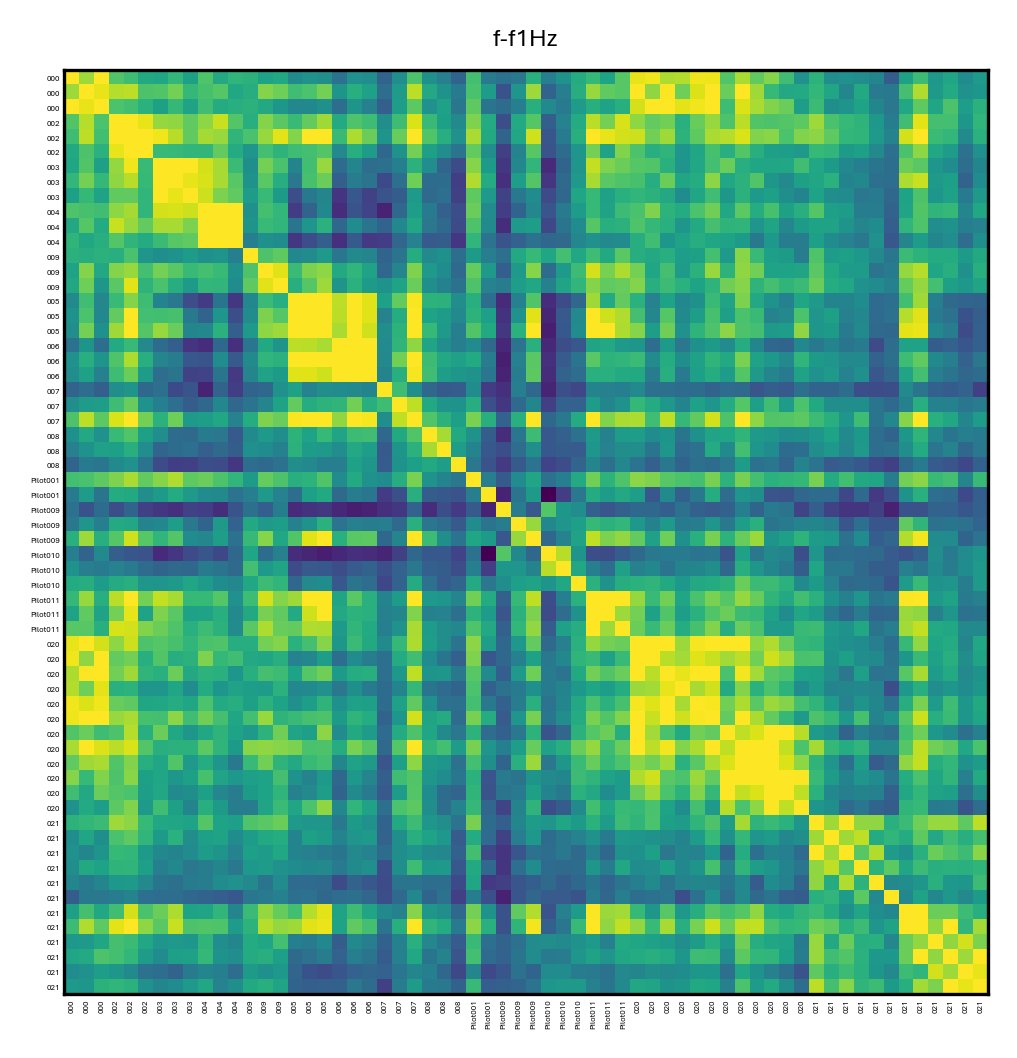

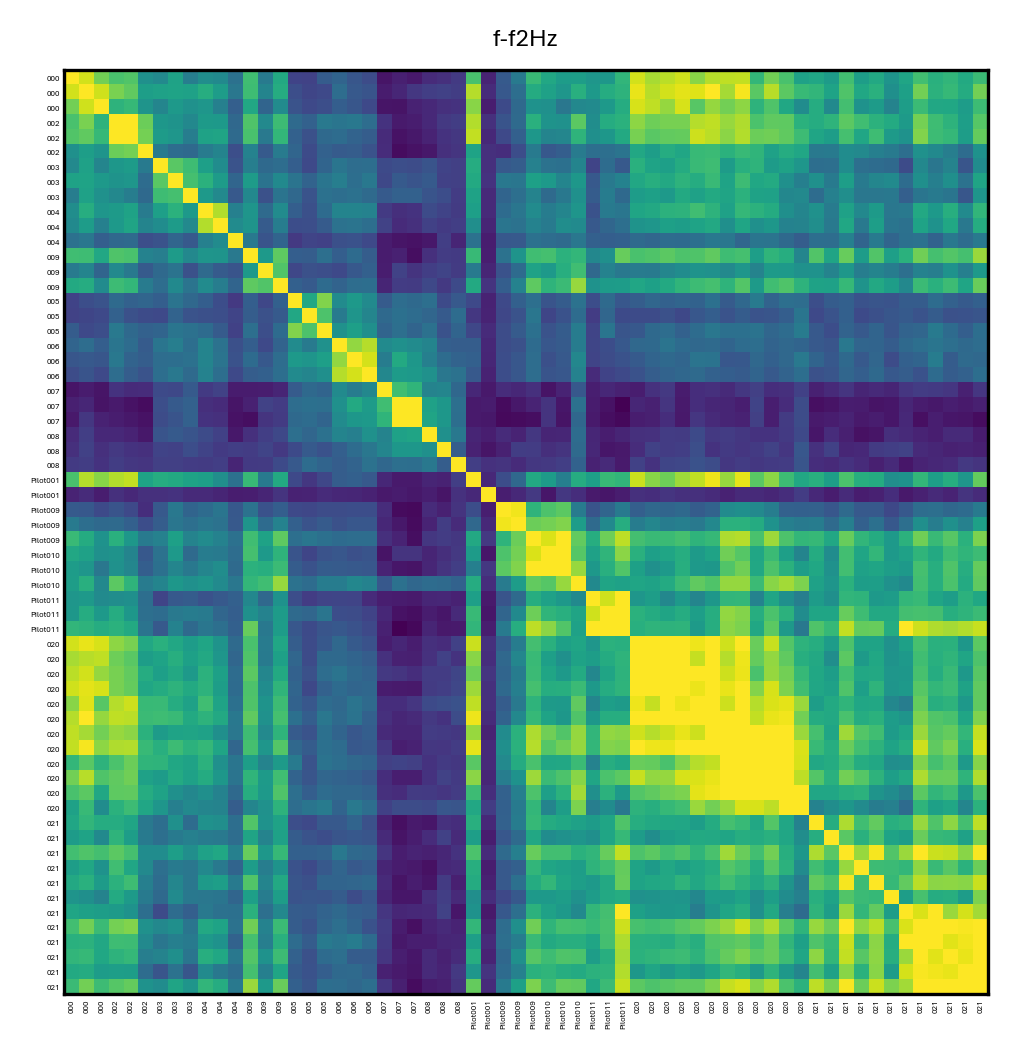

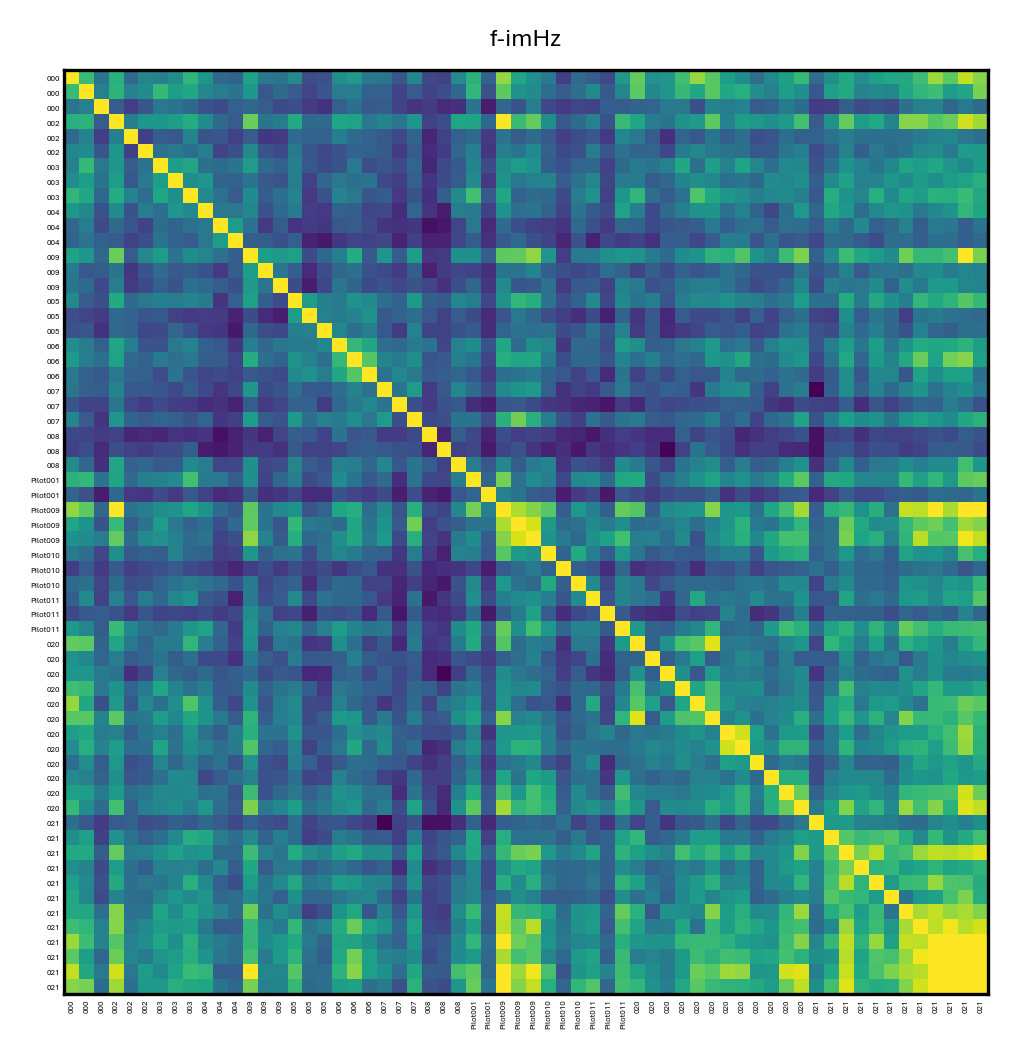

In [5]:

p_thr = .05
    
def dice_coefficient(col1, col2):
    intersection = np.sum(np.minimum(col1, col2))
    return 2 * intersection / (np.sum(col1) + np.sum(col2))

dice_matrix = {}
for f_type in ["f1", "f2", "im"]:
    
    # Global 
    mask = None
    n_masks = 0
    main_data = None
    run_ids = []
    run_data = None

    for sub_id in sub_ids:


        _all_masks = all_masks[f"{sub_id}_{f_type}"]
        _main_dscalar = main_dscalars[f"{sub_id}_{f_type}"][0]
        _run_dscalars = ses_dscalars[f"{sub_id}_{f_type}"]
        
        # 1 - 
        n_masks += len(_all_masks)
        for i in _all_masks:
            _mask = (nib.load(i).get_fdata() > 0).astype(float)
            if mask is None:
                mask = _mask
            else:
                mask += _mask

        # 2 - main dscalar
        _main_data = nib.load(_main_dscalar).get_fdata()[0,:VERTEX_TO]
        _main_data = (_main_data < p_thr).astype(float)
        _main_data = _main_data[None,:]
        if main_data is None:
            main_data = _main_data
        else:
            main_data = np.vstack((main_data,_main_data))

        # 3 - run-level dscalars
        for i in _run_dscalars:
            _run_data = nib.load(i).get_fdata()[0,:VERTEX_TO]
            _run_data = (_run_data < p_thr).astype(float)
            _run_data = _run_data[None,:]
            if run_data is None:
                run_data = _run_data
            else:
                run_data = np.vstack((run_data,_run_data))

            run_id = i.split("_run-")[-1].split("_")[0].split("X")[0]
            run_ids.append(f"{sub_id}_{run_id}")

    # Global mask 
    mask /= n_masks
    mask = (mask==1).astype(float)
    mask = mask[0,:VERTEX_TO]

    data = run_data[:,mask==1]

    # Compute n x n Dice coefficient matrix
    n = data.shape[0]
    _dice_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            _dice_matrix[i, j] = dice_coefficient(data[i,:], data[j,:])


    fig, ax = plt.subplots(dpi=300, figsize=(4,4))
    ax.imshow(_dice_matrix, cmap='viridis', vmax=.4)
    ax.set_xticks([i for i in range(n)])
    ax.set_xticklabels([i.split("_")[0] for i in run_ids], fontsize=2, rotation=90)
    ax.set_yticks([i for i in range(n)])
    ax.set_yticklabels([i.split("_")[0] for i in run_ids], fontsize=2)
    ax.tick_params(axis="both", pad=1, length=0)
    ax.set_title(f"f-{f_type}Hz", fontsize=6)

    dice_matrix[f_type] = _dice_matrix

Kolmogorov-Smirnov test across different groups of subjects comparing intra vs inter session map overlap

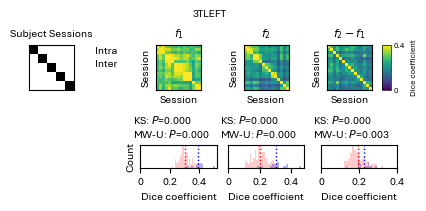

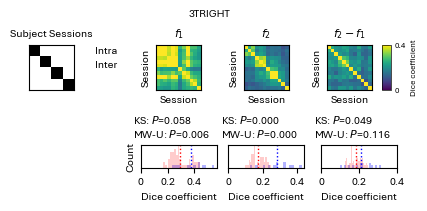

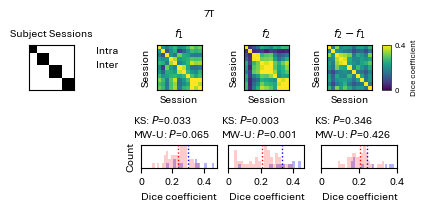

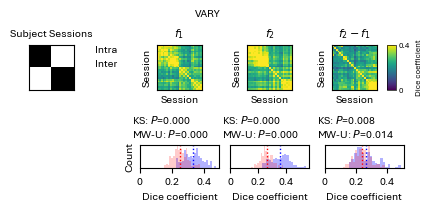

In [6]:

import pandas as pd
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

def filter_df(dice_matrix, f_type, run_ids, filtered_sub_ids):
    ax = [i.split("_")[0] for i in run_ids]
    df = pd.DataFrame(dice_matrix[f_type], index=ax, columns=ax)
    mask = np.tril(np.ones(df.shape, dtype=bool),k=-1)
    df = df.where(mask)
    df = df.reset_index()
    df = df[["index"]+filtered_sub_ids]
    df = df[df["index"].isin(filtered_sub_ids)]

    return df

map_type = "Session"
f_types = ["f1", "f2", "im"]
f_str = {
    "f1": "$f_{1}$",
    "f2": "$f_{2}$",
    "im": "$f_{2}-f_{1}$",
}
sub_id_groups = {
    "3TLEFT": ["000","002","003","004","009"],
    "3TRIGHT": ["005","006","007","008"],
    "7T":[
        "Pilot001", "Pilot009", "Pilot010", "Pilot011",
    ],
    "VARY":[
        "020","021"
    ],
}

for group, sub_ids in sub_id_groups.items():
    fig, ax_dict = plt.subplot_mosaic(
        mosaic=[
            ["BIN"]+[f"HM{f_type}" for f_type in f_types],
            ["0"]+f_types
        ], layout="constrained", figsize=(4,2), gridspec_kw={"height_ratios":[2,1]})
    fig.suptitle(group, fontsize=8)
    for f_type in f_types:
        ax = ax_dict[f_type]
        df = filter_df(dice_matrix, f_type, run_ids, sub_ids)
        intra_map_overlap = []
        inter_map_overlap = []
        for sub_id in sub_ids:
            row_filt = df["index"] == sub_id
            sub_map_overlap = [i for i in df[row_filt][sub_id].to_numpy().flatten() if ~np.isnan(i)]
            other_map_overlap = [i for i in df[~row_filt][sub_id].to_numpy().flatten() if ~np.isnan(i)]
            intra_map_overlap += sub_map_overlap
            inter_map_overlap += other_map_overlap

        ax.hist(intra_map_overlap, bins=20, alpha=.3, color="blue", label="Intrasubject overlap")
        ax.hist(inter_map_overlap, bins=20, alpha=.2, color="red", label="Intrasubject overlap")
        ax.axvline(x=np.mean(intra_map_overlap), color='blue', linewidth=1, linestyle="dotted")
        ax.axvline(x=np.mean(inter_map_overlap), color='red', linewidth=1, linestyle="dotted")
        statistic, pval = ks_2samp(intra_map_overlap, inter_map_overlap)
        mean_stat = mannwhitneyu(intra_map_overlap, inter_map_overlap)
        ax.set_title(f"KS: $P$={pval:.3f}\nMW-U: $P$={mean_stat.pvalue:.3f}", fontsize=8, ha="left", x=-.1)
        
        ax = ax_dict[f"HM{f_type}"]
        _ax = [i.split("_")[0] for i in run_ids]
        df = pd.DataFrame(dice_matrix[f_type], index=_ax, columns=_ax)
        df = df.reset_index()
        df = df[["index"]+sub_ids]
        df = df[df["index"].isin(sub_ids)]
        df = df.drop(columns=["index"])
        cax = ax.imshow(df, vmax=.4, vmin=0, interpolation="none")
        if f_type == "im":
            divider = make_axes_locatable(ax)
            cbar_ax = divider.append_axes("right", size="20%", pad=.1)
            cbar = fig.colorbar(cax, cax=cbar_ax)
            for s in cbar.ax.spines.values():
                s.set_linewidth(.5)
            cbar.ax.set_yticks([0,.4])
            cbar.ax.set_yticklabels([0,.4], fontsize=6)
            cbar.ax.tick_params(axis="both",width=.5,pad=2, length=1.4,direction='in', color='white')
            cbar.ax.set_ylabel("Dice coefficient",fontsize=6)

        if f_type == "f1":
            ax = ax_dict[f"BIN"]
            bin_map = np.zeros(df.shape)
            for i,x in enumerate(df.columns):
                for j,y in enumerate(df.columns):
                    if x==y:
                        bin_map[i,j] = 1
                    else:
                        bin_map[i,j] = 0
            ax.imshow(bin_map, cmap="Greys", interpolation="none")

        for k,ax in ax_dict.items():
            if k.startswith("BIN") or k.startswith("HM"):
                ax.set_xticks([])
                ax.set_yticks([])

        ax_dict["f1"].set_ylabel("Count", fontsize=8)
        for f_type in f_types:
            ax = ax_dict[f_type]
            ax.set_xticks([0,.2,.4])
            ax.set_xticklabels([0,.2,.4], fontsize=8)
            ax.set_yticks([])
            ax.set_xlabel("Dice coefficient", fontsize=8)
            ax = ax_dict[f"HM{f_type}"]
            ax.set_xlabel(map_type, fontsize=8)
            ax.set_ylabel(map_type, fontsize=8)
            ax_dict[f"HMf1"].set_title("$f_{1}$", fontsize=8)
            ax_dict[f"HMf2"].set_title("$f_{2}$", fontsize=8)
            ax_dict[f"HMim"].set_title("$f_{2}-f_{1}$", fontsize=8)
        ax_dict["0"].set_axis_off()
        
    ax = ax_dict["BIN"]
    ax.set_title(f"Subject {map_type}s", fontsize=8)
    y = (ax_dict["BIN"].get_xlim()[-1]+.5)
    ax.text(y+y*.44,y*.15,"Intra",fontsize=8)
    ax.text(y+y*.44,y*.45,"Inter",fontsize=8)

    fig.savefig(MAIN / f"session-level-map-repro-{group}.png", bbox_inches="tight", dpi=300)

KS test for single subject intra vs inter overlap test

In [ ]:
sub_ids = list(set([i.split("_")[0] for i in run_ids]))
sub_ids.sort()
for f_type in f_types:
    ax = ax_dict[f_type]
    df = filter_df(dice_matrix, f_type, run_ids, sub_ids)
    intra_map_overlap = []
    inter_map_overlap = []
    for sub_id in sub_ids:
        row_filt = df["index"] == sub_id
        sub_map_overlap = [i for i in df[row_filt][sub_id].to_numpy().flatten() if i!=1.]
        other_map_overlap = [i for i in df[~row_filt][sub_id].to_numpy().flatten() if i!=1.]
        statistic, pval = ks_2samp(sub_map_overlap, other_map_overlap)
        print(f"{f_type}: {sub_id}: {statistic}, {pval:.10f}")